# Model Building - RNN

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, RNN,SimpleRNN
from tensorflow.keras.layers import Dropout, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor


## Importing the pre-processed dataset

In [2]:
df = pd.read_excel('..\Data\gasoline_price_sentiment_pre-processed_7.xlsx', 'Sheet1')

In [3]:
df.set_index(keys='Date', drop= True, inplace= True)
df.drop('Unnamed: 0', inplace= True, axis= 1)

In [4]:
df.columns

Index(['price', 'popularity', 'general_sentiment', 'positive_outlook',
       'happiness', 'bittersweet', 'confidence', 'disgust', 'disagreement',
       'anxiety', 'gloominess', 'distress', 'violent', 'unexpectedness',
       'timeliness', 'confusion', 'feelingsVsTruth', 'buyVsSell',
       'buyVsSellForecast', 'priceTrend', 'pricePrediction', 'volatile',
       'consumptionCommodity', 'productionCommodity', 'regulatory',
       'supplyDemandBalance', 'supplyDemandBalanceForecast', 'exploration',
       'accidents', 'National_Holiday', 'Weekend', 'Holidays', 'happiness_Log',
       'bittersweet_Log', 'disgust_Log', 'disagreement_Log', 'anxiety_Log',
       'gloominess_Log', 'distress_Log', 'violent_Log', 'unexpectedness_Log',
       'confusion_Log', 'buyVsSell_sqrt', 'pricePrediction_Log',
       'volatile_Log', 'productionCommodity_Log', 'regulatory_Log',
       'supplyDemandBalance_Log', 'exploration_Log', 'accidents_Log',
       'month-1', 'month-2', 'month-3', 'month-4', 'month-5'

In [5]:
selected_variable_columns = ['price', 'happiness_Log', 'bittersweet_Log',
       'disgust_Log', 'disagreement_Log', 'anxiety_Log', 'gloominess_Log',
       'distress_Log', 'violent_Log', 'unexpectedness_Log', 'confusion_Log',
       'buyVsSell_sqrt', 'pricePrediction_Log', 'volatile_Log',
       'productionCommodity_Log', 'regulatory_Log', 'supplyDemandBalance_Log',
       'exploration_Log', 'accidents_Log', 'supplyDemandBalanceForecast', 
       'consumptionCommodity', 'priceTrend', 'buyVsSellForecast', 'feelingsVsTruth',
       'timeliness', 'confidence', 'popularity', 'general_sentiment', 'positive_outlook',
       'price_lag_7', 'price_rm', 'price_ewm', 'month-1', 'month-2', 
       'month-3', 'month-4', 'month-5', 'month-6', 'month-7', 'month-8', 
       'month-9', 'month-10', 'month-11', 'month-12', 'dayofweek-0',
       'dayofweek-1', 'dayofweek-2', 'dayofweek-3', 'dayofweek-4',
       'dayofweek-5', 'dayofweek-6', 'weekend', 'sunday']

#We are taking the transformed columns and the derived features

df_subset = df[selected_variable_columns]

## Train-test split

In [6]:
tr_start = '2010-01-08'
te_start = '2017-04-01' 
te_end = '2018-12-31'
tr_end = '2017-03-31'

In [7]:
train = df_subset[tr_start : tr_end]
test = df_subset[te_start : te_end]

## Standardization of Independent Variables

In [8]:
x_scaler = StandardScaler()

x_scaled = x_scaler.fit_transform(train.iloc[:, 1:])

y = np.reshape(np.array(train.iloc[:,0]), (-1,1))

train_scaled = np.hstack((x_scaled, y))

In [9]:
x_scaler = StandardScaler()

x_scaled = x_scaler.fit_transform(test.iloc[:, 1:])

y = np.reshape(np.array(test.iloc[:,0]), (-1,1))

test_scaled = np.hstack((x_scaled, y))

In [10]:
train_scaled.shape

(2640, 53)

In [11]:
test_scaled.shape

(640, 53)

## Preparing dataset for modelling

In [12]:
#Defining a function to split multivariate sequences into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [13]:
x_train, y_train = split_sequences(train_scaled, 7)

In [14]:
print(x_train.shape)
print(y_train.shape)

(2634, 7, 52)
(2634,)


In [15]:
x_test, y_test = split_sequences(test_scaled, 7)

In [16]:
print(x_test.shape)
print(y_test.shape)

(634, 7, 52)
(634,)


## Model-building

### Setting seed

In [17]:
#Set seed to ensure reproducibility
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

#Setting seed value as 7
set_seed(7)


### Baseline Model (RNN)

In [18]:
base_RNN = Sequential()

base_RNN.add(SimpleRNN(units = 32, activation = 'relu', input_shape = (7,52), return_sequences = True))
base_RNN.add(SimpleRNN(units = 32, activation = 'relu', return_sequences = True))
base_RNN.add(SimpleRNN(units = 16, activation = 'relu', return_sequences = False))
base_RNN.add(Dense(units = 1, activation='linear'))

base_RNN.compile(optimizer = 'adam', loss = 'mse')
base_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 7, 32)             2720      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 7, 32)             2080      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 16)                784       
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 5,601
Trainable params: 5,601
Non-trainable params: 0
_________________________________________________________________


In [19]:
base_RNN.compile(optimizer = 'adam', loss = 'mse')
base_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 7, 32)             2720      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 7, 32)             2080      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 16)                784       
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 5,601
Trainable params: 5,601
Non-trainable params: 0
_________________________________________________________________


In [20]:
base_RNN.fit(x_train, y_train, epochs = 100, validation_split= 0.2, batch_size=32)

Epoch 1/100
66/66 [==============================] - 8s 29ms/step - loss: 4622.0137 - val_loss: 357.1938
Epoch 2/100
66/66 [==============================] - 1s 15ms/step - loss: 244.3631 - val_loss: 212.0308
Epoch 3/100
66/66 [==============================] - 1s 15ms/step - loss: 130.6016 - val_loss: 155.6626
Epoch 4/100
66/66 [==============================] - 1s 15ms/step - loss: 95.8689 - val_loss: 174.8716
Epoch 5/100
66/66 [==============================] - 1s 15ms/step - loss: 74.9556 - val_loss: 153.5200
Epoch 6/100
66/66 [==============================] - 1s 14ms/step - loss: 61.7470 - val_loss: 165.4415
Epoch 7/100
66/66 [==============================] - 1s 15ms/step - loss: 55.7878 - val_loss: 166.8568
Epoch 8/100
66/66 [==============================] - 1s 16ms/step - loss: 45.5829 - val_loss: 142.7180
Epoch 9/100
66/66 [==============================] - 1s 16ms/step - loss: 39.4120 - val_loss: 151.1597
Epoch 10/100
66/66 [==============================] - 1s 16ms/step - 

In [21]:
pred_RNN = base_RNN.predict(x_train)
print('The MSE for the baseline RNN model is: {0:.2f}'.format(mean_squared_error(y_train, pred_RNN)))
print('The RMSE for the baseline RNN model is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_train, pred_RNN))))
print('The MAPE for the baseline RNN model is {0:.2f}'.format(mean_absolute_percentage_error(y_train, pred_RNN)))

83/83 [==============================] - 1s 6ms/step
The MSE for the baseline RNN model is: 16.66
The RMSE for the baseline RNN model is: 4.08
The MAPE for the baseline RNN model is 0.03


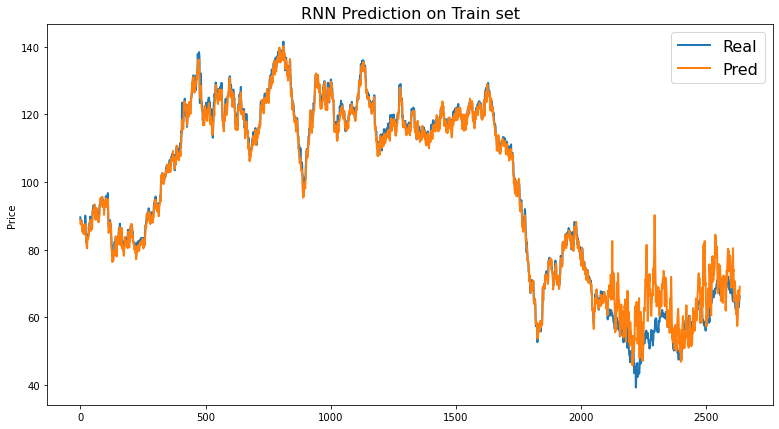

In [22]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_train, label='Real', linewidth=2)
ax.plot(pred_RNN, label='Pred', linewidth=2)
ax.set_ylabel('Price')
ax.set_title('RNN Prediction on Train set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

In [23]:
pred_RNN = base_RNN.predict(x_test)
print('The MSE for the baseline RNN model is: {0:.2f}'.format(mean_squared_error(y_test, pred_RNN)))
print('The RMSE for the baseline RNN model is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, pred_RNN))))
print('The MAPE for the baseline RNN model is {0:.2f}'.format(mean_absolute_percentage_error(y_test, pred_RNN)))

20/20 [==============================] - 0s 6ms/step
The MSE for the baseline RNN model is: 803.47
The RMSE for the baseline RNN model is: 28.35
The MAPE for the baseline RNN model is 0.29


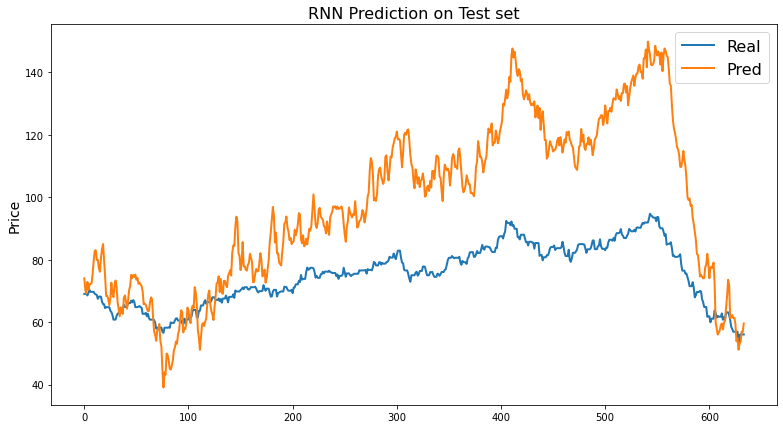

In [24]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_test, label='Real', linewidth=2)
ax.plot(pred_RNN, label='Pred', linewidth=2)
ax.set_ylabel('Price', fontsize=14)
ax.set_title('RNN Prediction on Test set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

### Hyperparameter Tuning (Grid Search)

#### Epochs and Batch Size

In [25]:
def create_RNN(optimizer = 'adam'):
    model = Sequential()

    model.add(SimpleRNN(units = 32, activation = 'relu', input_shape = (7,52), return_sequences = True))
    model.add(SimpleRNN(units = 32, activation = 'relu', return_sequences = True))
    model.add(SimpleRNN(units = 16, activation = 'relu', return_sequences = False))
    model.add(Dense(units = 1, activation='linear'))

    model.compile(optimizer = optimizer, loss = 'mse')

    return(model)

In [26]:
base_RNN = KerasRegressor(build_fn=create_RNN, verbose=1)

#Defining the grid search parameters
batch_size = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
epochs = [10, 30, 50, 70, 90]
scoring = ['neg_mean_squared_error','neg_mean_absolute_error','neg_mean_absolute_percentage_error']

#Grid search
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=base_RNN, param_grid=param_grid, n_jobs=-1, cv=5, scoring=scoring, refit=False)
# epoch_batch_size_result = grid.fit(x_train, y_train)

# grid = GridSearchCV(estimator=base_RNN, param_grid=param_grid,scoring = scoring,refit="neg_mean_absolute_percentage_error")
grid_result = grid.fit(x_train, y_train)

C:\Users\sidizainulabideen.a\AppData\Local\Temp\ipykernel_20960\3104044985.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  base_RNN = KerasRegressor(build_fn=create_RNN, verbose=1)


In [27]:
Gr_Df=pd.DataFrame(grid_result.cv_results_)
Gr_Df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_epochs,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
0,17.459516,0.612494,4.628465,0.353111,0,10,"{'batch_size': 0, 'epochs': 10}",-157.272512,-88.885659,-60.602223,...,0.938898,46,-0.092850,-0.061899,-0.053588,-0.094783,-0.113281,-0.083280,0.022194,44
1,33.883984,2.832194,3.902376,3.393317,0,30,"{'batch_size': 0, 'epochs': 30}",-65.435024,-49.738112,-32.399738,...,0.616214,14,-0.065759,-0.046740,-0.037629,-0.064757,-0.098342,-0.062645,0.020819,11
2,57.586631,5.035165,3.411427,0.210863,0,50,"{'batch_size': 0, 'epochs': 50}",-59.708597,-32.113427,-34.423243,...,0.470779,8,-0.059570,-0.037008,-0.039320,-0.058929,-0.097673,-0.058500,0.021752,7
3,86.238784,4.530573,4.921678,1.702761,0,70,"{'batch_size': 0, 'epochs': 70}",-78.602807,-49.396039,-44.050609,...,1.034697,26,-0.064923,-0.045481,-0.045335,-0.056235,-0.137174,-0.069830,0.034459,27
4,100.960412,10.376522,4.012341,1.271040,0,90,"{'batch_size': 0, 'epochs': 90}",-47.888090,-35.455258,-37.348894,...,0.421697,9,-0.053469,-0.037534,-0.040844,-0.060854,-0.103262,-0.059193,0.023594,9
5,53.091659,7.587961,4.829580,1.578351,10,10,"{'batch_size': 10, 'epochs': 10}",-75.997979,-64.579916,-38.984550,...,0.906506,32,-0.063916,-0.052164,-0.042035,-0.067697,-0.135612,-0.072285,0.032928,31
6,96.641374,5.460418,6.419588,2.014841,10,30,"{'batch_size': 10, 'epochs': 30}",-51.586340,-31.172208,-28.802346,...,0.856087,5,-0.048122,-0.036793,-0.035856,-0.053549,-0.117772,-0.058418,0.030428,6
7,173.965294,8.090999,8.506538,2.182358,10,50,"{'batch_size': 10, 'epochs': 50}",-45.389910,-40.737347,-28.346871,...,1.075195,10,-0.052535,-0.041664,-0.035544,-0.051158,-0.128453,-0.061871,0.033872,10
8,231.074356,9.202088,10.868248,2.125863,10,70,"{'batch_size': 10, 'epochs': 70}",-31.444628,-28.854935,-35.479957,...,0.450861,1,-0.045419,-0.035169,-0.038880,-0.051517,-0.097552,-0.053707,0.022625,1
9,283.756329,7.573127,6.385592,1.526317,10,90,"{'batch_size': 10, 'epochs': 90}",-38.321100,-32.409418,-23.290404,...,1.001800,3,-0.046618,-0.037981,-0.033051,-0.048739,-0.119886,-0.057255,0.031829,4


In [28]:
def generate_grid_search_results_rank(GR_Result):

    Gr_Df=pd.DataFrame(GR_Result.cv_results_)

    for i in Gr_Df.index:
        check = 0

        sum=Gr_Df['rank_test_neg_mean_squared_error'][i]+Gr_Df['rank_test_neg_mean_absolute_error'][i]+Gr_Df['rank_test_neg_mean_absolute_percentage_error'][i]

        if sum == 3:
            check = 1
            Params=Gr_Df['params'][i]
            print("Parameter of {}".format(Params) + " achieve all rank 1 for metrics evaluation.")

            break
            


    if check == 0:
        Params=Gr_Df.loc[(Gr_Df['rank_test_neg_mean_absolute_percentage_error'] == 1), 'params'].iloc[0]
        print("Parameter of {}".format(Params) + " achieve rank 1 for MAPE.")
        print("Suggest to check the csv file of the current hypertuning process.")
    

In [29]:
def generate_dataframe_grid_search_results(GR_Result,fname):
    Gr_Df=pd.DataFrame(GR_Result.cv_results_)
    Gr_Df.to_csv("{}_.csv".format(fname))
    print("Saved.")


In [30]:
#Displaying grid search results (epochs and batch size)
generate_grid_search_results_rank(grid_result)

Parameter of {'batch_size': 10, 'epochs': 70} achieve all rank 1 for metrics evaluation.


In [69]:
fname = "RNN Base Result Epoch and Batch"
generate_dataframe_grid_search_results(grid_result,fname)

Saved.


#### Optimizer

In [31]:
base_RNN= KerasRegressor(build_fn=create_RNN, verbose=0)

#Define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
scoring = ['neg_mean_squared_error','neg_mean_absolute_error','neg_mean_absolute_percentage_error']

#Grid search
grid = GridSearchCV(estimator=base_RNN, param_grid=param_grid, n_jobs=-1, cv=5, scoring=scoring, refit=False)
optimizer_result = grid.fit(x_train, y_train,batch_size= 10, epochs= 70)

C:\Users\sidizainulabideen.a\AppData\Local\Temp\ipykernel_20960\195890433.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  base_RNN= KerasRegressor(build_fn=create_RNN, verbose=0)
c:\Users\sidizainulabideen.a\.conda\envs\SidiEnv\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [           nan   -42.34317546  -185.23365684 -4043.82050425
   -34.7925704    -41.31242122   -44.56101268]
  warnings.warn(
c:\Users\sidizainulabideen.a\.conda\envs\SidiEnv\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [         nan  -5.2547941  -10.25186391 -57.87274578  -4.5866829
  -4.98454118  -5.24207075]
  warnings.warn(
c:\Users\sidizainulabideen.a\.conda\envs\SidiEnv\lib\site-packages\sklearn\model_selection\_search.p

In [32]:
generate_grid_search_results_rank(optimizer_result)

Parameter of {'optimizer': 'Adam'} achieve all rank 1 for metrics evaluation.


In [33]:
fname = "RNN Base Result Optimizer"
generate_dataframe_grid_search_results(optimizer_result,fname)

Saved.


### Optimized Model (RNN)



In [26]:
opt_RNN = Sequential()

opt_RNN.add(SimpleRNN(units = 32, activation = 'relu', input_shape = (7,52), return_sequences = True))
opt_RNN.add(SimpleRNN(units = 32, activation = 'relu', return_sequences = True))
opt_RNN.add(SimpleRNN(units = 16, activation = 'relu', return_sequences = False))
opt_RNN.add(Dense(units = 1, activation='linear'))

opt_RNN.compile(optimizer = 'Adam', loss = 'mse')
opt_RNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 7, 32)             2720      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 7, 32)             2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 16)                784       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5,601
Trainable params: 5,601
Non-trainable params: 0
_________________________________________________________________


In [27]:
opt_RNN.fit(x_train, y_train, batch_size= 10, epochs= 70)

Epoch 1/70
264/264 [==============================] - 8s 14ms/step - loss: 2073.7778
Epoch 2/70
264/264 [==============================] - 3s 13ms/step - loss: 100.9792
Epoch 3/70
264/264 [==============================] - 4s 14ms/step - loss: 60.9471
Epoch 4/70
264/264 [==============================] - 3s 13ms/step - loss: 42.6442
Epoch 5/70
264/264 [==============================] - 3s 12ms/step - loss: 32.4818
Epoch 6/70
264/264 [==============================] - 3s 12ms/step - loss: 25.5846
Epoch 7/70
264/264 [==============================] - 3s 11ms/step - loss: 20.4839
Epoch 8/70
264/264 [==============================] - 3s 11ms/step - loss: 16.8121
Epoch 9/70
264/264 [==============================] - 3s 11ms/step - loss: 14.1643
Epoch 10/70
264/264 [==============================] - 3s 12ms/step - loss: 13.5365
Epoch 11/70
264/264 [==============================] - 3s 11ms/step - loss: 11.4297
Epoch 12/70
264/264 [==============================] - 4s 14ms/step - loss: 11.133

In [28]:
pred_rnn = opt_RNN.predict(x_train)
print('The MSE for the baseline RNN model is: {0:.2f}'.format(mean_squared_error(y_train, pred_rnn)))
print('The RMSE for the baseline RNN model is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_train, pred_rnn))))
print('The MAPE for the baseline RNN model is {0:.2f}'.format(mean_absolute_percentage_error(y_train, pred_rnn)))

83/83 [==============================] - 1s 5ms/step
The MSE for the baseline RNN model is: 2.27
The RMSE for the baseline RNN model is: 1.51
The MAPE for the baseline RNN model is 0.01


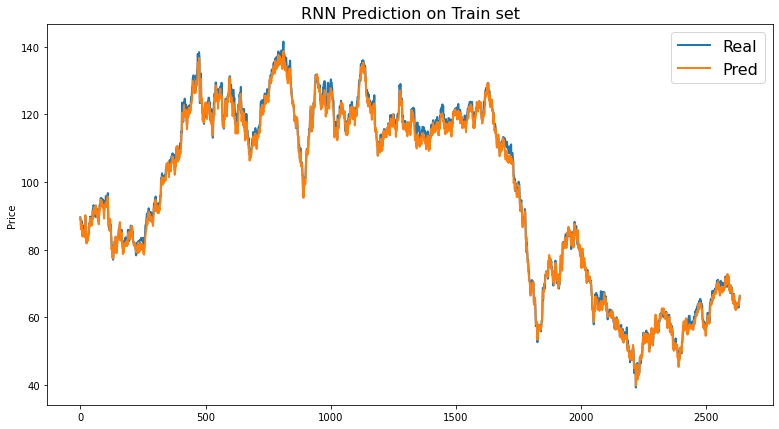

In [29]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_train, label='Real', linewidth=2)
ax.plot(pred_rnn, label='Pred', linewidth=2)
ax.set_ylabel('Price')
ax.set_title('RNN Prediction on Train set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

In [30]:
pred_rnn = opt_RNN.predict(x_test)
print('The MSE for the baseline RNN model is: {0:.2f}'.format(mean_squared_error(y_test, pred_rnn)))
print('The RMSE for the baseline RNN model is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, pred_rnn))))
print('The MAPE for the baseline RNN model is {0:.2f}'.format(mean_absolute_percentage_error(y_test, pred_rnn)))

20/20 [==============================] - 0s 5ms/step
The MSE for the baseline RNN model is: 768.88
The RMSE for the baseline RNN model is: 27.73
The MAPE for the baseline RNN model is 0.28


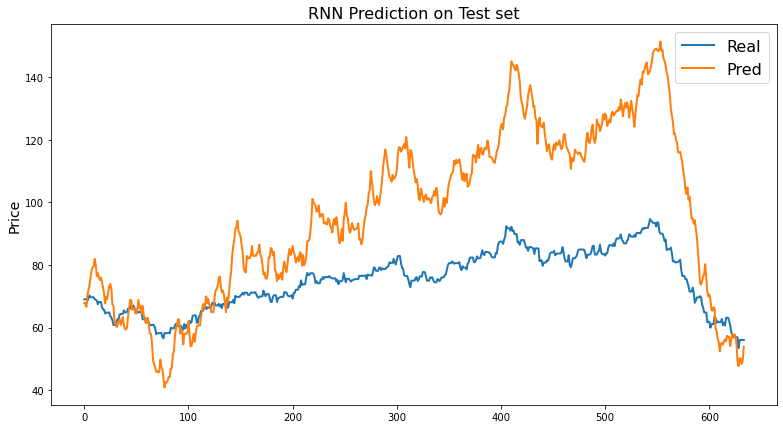

In [31]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_test, label='Real', linewidth=2)
ax.plot(pred_rnn, label='Pred', linewidth=2)
ax.set_ylabel('Price', fontsize=14)
ax.set_title('RNN Prediction on Test set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

### Baseline Model (RNN) with Early Stopping

In [32]:
opt_RNN_es = Sequential()

opt_RNN_es.add(SimpleRNN(units = 32, activation = 'relu', input_shape = (7,52), return_sequences = True))
opt_RNN_es.add(SimpleRNN(units = 32, activation = 'relu', return_sequences = True))
opt_RNN_es.add(SimpleRNN(units = 16, activation = 'relu', return_sequences = False))
opt_RNN_es.add(Dense(units = 1, activation='linear'))

opt_RNN_es.compile(optimizer = 'Adam', loss = 'mse')
opt_RNN_es.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 7, 32)             2720      
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 7, 32)             2080      
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 16)                784       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5,601
Trainable params: 5,601
Non-trainable params: 0
_________________________________________________________________


In [33]:
#Defining early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    min_delta=1,
    verbose=2,
    mode="auto",
    restore_best_weights=True )

In [34]:
opt_RNN_es.fit(x_train, y_train, epochs = 70, validation_split= 0.2, batch_size=10, callbacks= [early_stopping])

Epoch 1/70
211/211 [==============================] - 6s 14ms/step - loss: 2026.2738 - val_loss: 194.4617
Epoch 2/70
211/211 [==============================] - 2s 11ms/step - loss: 104.2734 - val_loss: 145.7798
Epoch 3/70
211/211 [==============================] - 2s 11ms/step - loss: 67.5743 - val_loss: 195.7580
Epoch 4/70
211/211 [==============================] - 2s 11ms/step - loss: 48.1728 - val_loss: 177.2623
Epoch 5/70
211/211 [==============================] - 2s 11ms/step - loss: 37.5419 - val_loss: 113.2305
Epoch 6/70
211/211 [==============================] - 2s 11ms/step - loss: 30.4809 - val_loss: 112.5745
Epoch 7/70
211/211 [==============================] - 2s 11ms/step - loss: 23.7654 - val_loss: 93.0397
Epoch 8/70
211/211 [==============================] - 2s 11ms/step - loss: 21.0974 - val_loss: 111.0052
Epoch 9/70
211/211 [==============================] - 2s 11ms/step - loss: 18.4034 - val_loss: 120.7757
Epoch 10/70
211/211 [==============================] - 2s 11ms

In [35]:
pred_rnn = opt_RNN_es.predict(x_train)
print('The MSE for the baseline RNN model is: {0:.2f}'.format(mean_squared_error(y_train, pred_rnn)))
print('The RMSE for the baseline RNN model is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_train, pred_rnn))))
print('The MAPE for the baseline RNN model is {0:.2f}'.format(mean_absolute_percentage_error(y_train, pred_rnn)))

83/83 [==============================] - 1s 4ms/step
The MSE for the baseline RNN model is: 15.14
The RMSE for the baseline RNN model is: 3.89
The MAPE for the baseline RNN model is 0.03


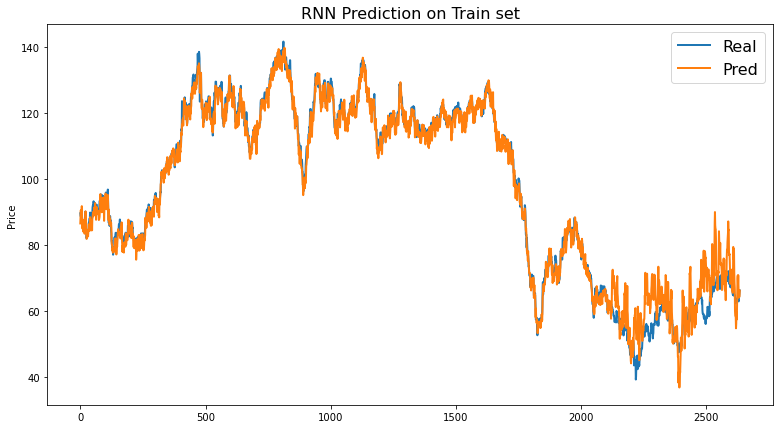

In [36]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_train, label='Real', linewidth=2)
ax.plot(pred_rnn, label='Pred', linewidth=2)
ax.set_ylabel('Price')
ax.set_title('RNN Prediction on Train set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

In [37]:
pred_rnn = opt_RNN_es.predict(x_test)
print('The MSE for the baseline RNN model is: {0:.2f}'.format(mean_squared_error(y_test, pred_rnn)))
print('The RMSE for the baseline RNN model is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, pred_rnn))))
print('The MAPE for the baseline RNN model is {0:.2f}'.format(mean_absolute_percentage_error(y_test, pred_rnn)))

20/20 [==============================] - 0s 5ms/step
The MSE for the baseline RNN model is: 801.39
The RMSE for the baseline RNN model is: 28.31
The MAPE for the baseline RNN model is 0.29


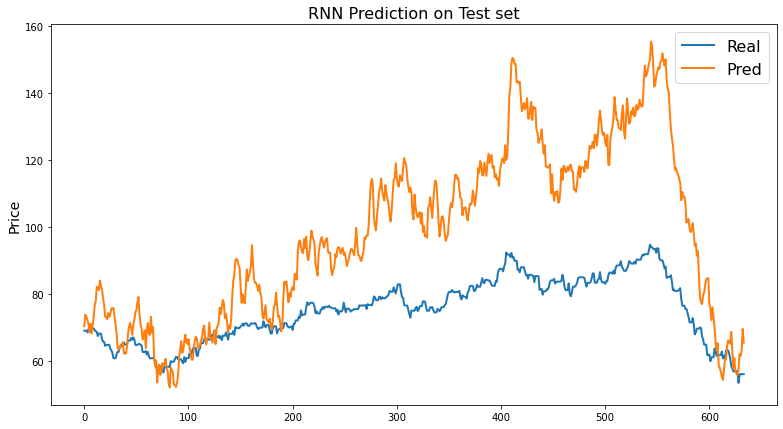

In [38]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_test, label='Real', linewidth=2)
ax.plot(pred_rnn, label='Pred', linewidth=2)
ax.set_ylabel('Price', fontsize=14)
ax.set_title('RNN Prediction on Test set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

### RNN with Dropout Layers and Early Stopping

In [39]:
dropout_RNN = Sequential()

dropout_RNN.add(SimpleRNN(units = 32, activation = 'relu', input_shape = (7,52), return_sequences = True))
dropout_RNN.add(Dropout(0.2))
dropout_RNN.add(SimpleRNN(units = 32, activation = 'relu', return_sequences = True))
dropout_RNN.add(Dropout(0.2))
dropout_RNN.add(SimpleRNN(units = 16, activation = 'relu', return_sequences = False))
dropout_RNN.add(Dense(units = 1, activation='linear'))

dropout_RNN.compile(optimizer = 'Adam', loss = 'mse')
dropout_RNN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_9 (SimpleRNN)    (None, 7, 32)             2720      
                                                                 
 dropout (Dropout)           (None, 7, 32)             0         
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 7, 32)             2080      
                                                                 
 dropout_1 (Dropout)         (None, 7, 32)             0         
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 16)                784       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5,601
Trainable params: 5,601
Non-traina

In [40]:
dropout_RNN.fit(x_train, y_train, epochs = 70, validation_split= 0.2, batch_size=10, callbacks= [early_stopping])

Epoch 1/70
211/211 [==============================] - 7s 15ms/step - loss: 3429.8765 - val_loss: 177.6049
Epoch 2/70
211/211 [==============================] - 2s 11ms/step - loss: 265.1871 - val_loss: 88.9678
Epoch 3/70
211/211 [==============================] - 2s 11ms/step - loss: 187.9309 - val_loss: 74.8297
Epoch 4/70
211/211 [==============================] - 2s 12ms/step - loss: 146.6925 - val_loss: 134.6815
Epoch 5/70
211/211 [==============================] - 2s 11ms/step - loss: 121.2360 - val_loss: 74.1612
Epoch 6/70
211/211 [==============================] - 2s 11ms/step - loss: 115.2427 - val_loss: 122.0306
Epoch 7/70
211/211 [==============================] - 2s 12ms/step - loss: 102.6750 - val_loss: 67.2630
Epoch 8/70
211/211 [==============================] - 2s 11ms/step - loss: 84.1248 - val_loss: 59.8100
Epoch 9/70
211/211 [==============================] - 2s 12ms/step - loss: 80.2123 - val_loss: 71.3377
Epoch 10/70
211/211 [==============================] - 2s 11ms

In [41]:
pred_rnn = dropout_RNN.predict(x_train)
print('The MSE for the baseline RNN model is: {0:.2f}'.format(mean_squared_error(y_train, pred_rnn)))
print('The RMSE for the baseline RNN model is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_train, pred_rnn))))
print('The MAPE for the baseline RNN model is {0:.2f}'.format(mean_absolute_percentage_error(y_train, pred_rnn)))

83/83 [==============================] - 1s 5ms/step
The MSE for the baseline RNN model is: 174.72
The RMSE for the baseline RNN model is: 13.22
The MAPE for the baseline RNN model is 0.12


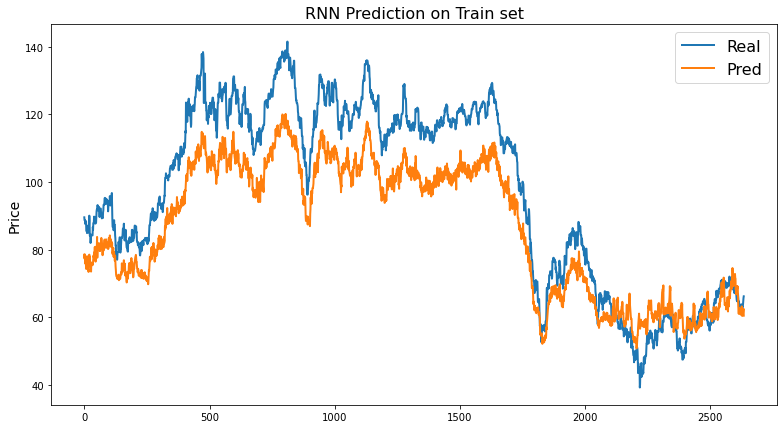

In [42]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_train, label='Real', linewidth=2)
ax.plot(pred_rnn, label='Pred', linewidth=2)
ax.set_ylabel('Price', fontsize=14)
ax.set_title('RNN Prediction on Train set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

In [43]:
pred_rnn = dropout_RNN.predict(x_test)
print('The MSE for the baseline RNN model is: {0:.2f}'.format(mean_squared_error(y_test, pred_rnn)))
print('The RMSE for the baseline RNN model is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, pred_rnn))))
print('The MAPE for the baseline RNN model is {0:.2f}'.format(mean_absolute_percentage_error(y_test, pred_rnn)))

20/20 [==============================] - 0s 9ms/step
The MSE for the baseline RNN model is: 282.41
The RMSE for the baseline RNN model is: 16.81
The MAPE for the baseline RNN model is 0.16


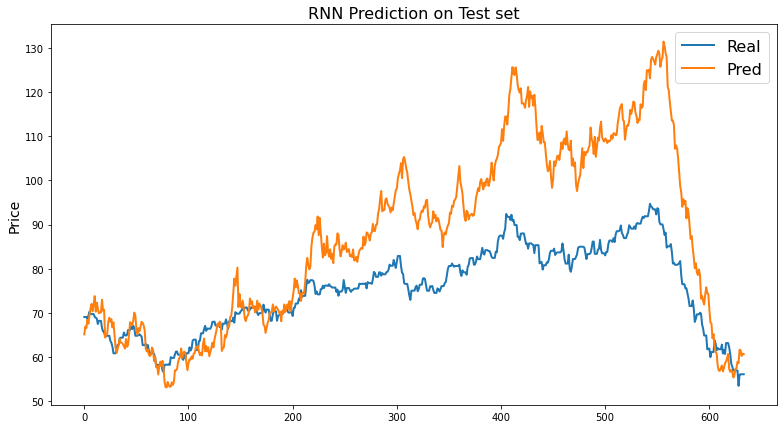

In [44]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_test, label='Real', linewidth=2)
ax.plot(pred_rnn, label='Pred', linewidth=2)
ax.set_ylabel('Price', fontsize=14)
ax.set_title('RNN Prediction on Test set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

### Less Complex Architecture, reducint number of neuron, add dropout layer.

In [45]:
model_RNN = Sequential()
model_RNN.add(SimpleRNN(units = 16, activation = 'relu', input_shape = (7,52), return_sequences = True))
model_RNN.add(SimpleRNN(units = 10, activation = 'relu', return_sequences = False))
model_RNN.add(Dropout(0.2))
model_RNN.add(Dense(units = 1, activation='linear'))

model_RNN.compile(optimizer = 'RMSprop', loss = 'mse')
model_RNN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, 7, 16)             1104      
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 10)                270       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,385
Trainable params: 1,385
Non-trainable params: 0
_________________________________________________________________


In [46]:
model_RNN.fit(x_train, y_train, epochs = 50)

Epoch 1/50
83/83 [==============================] - 4s 9ms/step - loss: 5420.1348
Epoch 2/50
83/83 [==============================] - 1s 10ms/step - loss: 1024.1349
Epoch 3/50
83/83 [==============================] - 1s 10ms/step - loss: 823.0761
Epoch 4/50
83/83 [==============================] - 1s 10ms/step - loss: 711.2590
Epoch 5/50
83/83 [==============================] - 1s 11ms/step - loss: 681.1617
Epoch 6/50
83/83 [==============================] - 1s 9ms/step - loss: 770.3272
Epoch 7/50
83/83 [==============================] - 1s 8ms/step - loss: 641.8743
Epoch 8/50
83/83 [==============================] - 1s 9ms/step - loss: 688.1259
Epoch 9/50
83/83 [==============================] - 1s 10ms/step - loss: 635.6552
Epoch 10/50
83/83 [==============================] - 1s 10ms/step - loss: 646.9358
Epoch 11/50
83/83 [==============================] - 1s 11ms/step - loss: 631.7885
Epoch 12/50
83/83 [==============================] - 1s 10ms/step - loss: 642.5016
Epoch 13/50
83/

In [47]:
pred_rnn = model_RNN.predict(x_train)
print('The MSE for the baseline RNN model is: {0:.2f}'.format(mean_squared_error(y_train, pred_rnn)))
print('The RMSE for the baseline RNN model is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_train, pred_rnn))))
print('The MAPE for the baseline RNN model is {0:.2f}'.format(mean_absolute_percentage_error(y_train, pred_rnn)))

83/83 [==============================] - 1s 6ms/step
The MSE for the baseline RNN model is: 49.05
The RMSE for the baseline RNN model is: 7.00
The MAPE for the baseline RNN model is 0.06


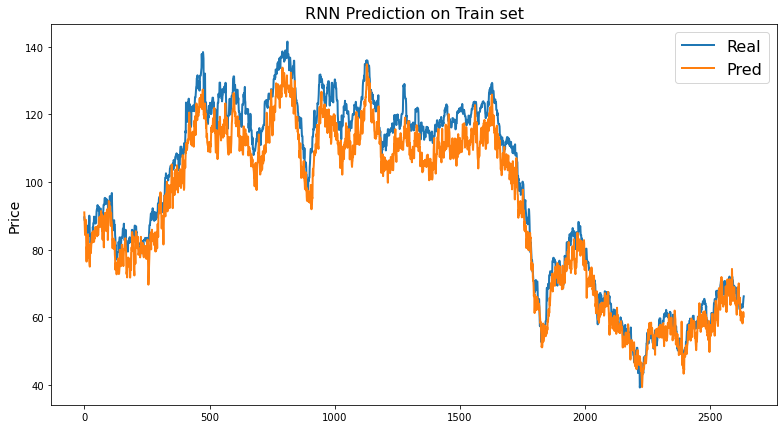

In [48]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_train, label='Real', linewidth=2)
ax.plot(pred_rnn, label='Pred', linewidth=2)
ax.set_ylabel('Price', fontsize=14)
ax.set_title('RNN Prediction on Train set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

In [49]:
pred_rnn = dropout_RNN.predict(x_test)
print('The MSE for the baseline RNN model is: {0:.2f}'.format(mean_squared_error(y_test, pred_rnn)))
print('The RMSE for the baseline RNN model is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, pred_rnn))))
print('The MAPE for the baseline RNN model is {0:.2f}'.format(mean_absolute_percentage_error(y_test, pred_rnn)))

20/20 [==============================] - 0s 6ms/step
The MSE for the baseline RNN model is: 282.41
The RMSE for the baseline RNN model is: 16.81
The MAPE for the baseline RNN model is 0.16


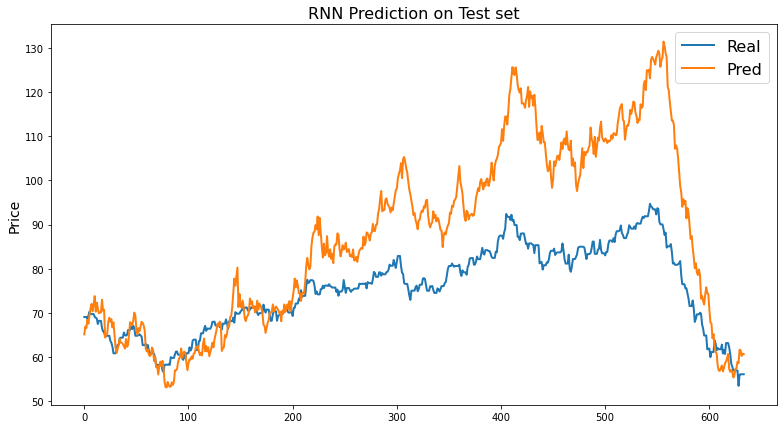

In [50]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_test, label='Real', linewidth=2)
ax.plot(pred_rnn, label='Pred', linewidth=2)
ax.set_ylabel('Price', fontsize=14)
ax.set_title('RNN Prediction on Test set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

## Hypertuning less complex RNN

In [21]:
def create_DCRNN(optimizer = 'RMSprop'):
    model_RNN = Sequential()
    model_RNN.add(SimpleRNN(units = 16, activation = 'relu', input_shape = (7,52), return_sequences = True))
    model_RNN.add(SimpleRNN(units = 10, activation = 'relu', return_sequences = False))
    model_RNN.add(Dropout(0.2))
    model_RNN.add(Dense(units = 1, activation='linear'))

    model_RNN.compile(optimizer = optimizer, loss = 'mse')
    model_RNN.summary()

    return(model_RNN)

# base_RNN = KerasRegressor(build_fn=create_DCRNN, verbose=1)

# #Defining the grid search parameters
# batch_size = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# epochs = [10, 30, 50, 70, 90]
# scoring = ['neg_mean_squared_error','neg_mean_absolute_error','neg_mean_absolute_percentage_error']

# #Grid search
# param_grid = dict(batch_size=batch_size, epochs=epochs)
# grid = GridSearchCV(estimator=base_RNN, param_grid=param_grid, n_jobs=-1, cv=5, scoring=scoring, refit=False)
# grid_result = grid.fit(x_train, y_train, callbacks=[early_stopping],validation_split= 0.2)

In [23]:
generate_grid_search_results_rank(grid_result)
fname = "RNN DeComplex Base Result Optimizer"
generate_dataframe_grid_search_results(grid_result,fname)

Parameter of {'batch_size': 20, 'epochs': 50} achieve all rank 1 for metrics evaluation.
Saved.


In [22]:
base_RNN = KerasRegressor(build_fn=create_DCRNN, verbose=1)

#Defining the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
scoring = ['neg_mean_squared_error','neg_mean_absolute_error','neg_mean_absolute_percentage_error']

#Grid search
grid = GridSearchCV(estimator=base_RNN, param_grid=param_grid, n_jobs=-1, cv=5, scoring=scoring, refit=False)
grid_result_optimizer = grid.fit(x_train, y_train, callbacks=[early_stopping], batch_size=20,epochs=50,validation_split= 0.2)

C:\Users\sidizainulabideen.a\AppData\Local\Temp\ipykernel_15832\1911558615.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  base_RNN = KerasRegressor(build_fn=create_DCRNN, verbose=1)
c:\Users\sidizainulabideen.a\.conda\envs\SidiEnv\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [            nan    -93.61871411   -976.64536951 -10190.69269294
    -94.46699805   -187.85334557    -91.36105034]
  warnings.warn(
c:\Users\sidizainulabideen.a\.conda\envs\SidiEnv\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [         nan  -7.6477964  -26.20746116 -97.50534385  -7.84517854
 -11.20177962  -7.70207573]
  warnings.warn(
c:\Users\sidizainulabideen.a\.conda\envs\SidiEnv\lib\site-packages\sklearn\model_selecti

In [23]:
generate_grid_search_results_rank(grid_result_optimizer)
fname = "RNN DeComplex Base Result Optimizer + optimized parameter"
generate_dataframe_grid_search_results(grid_result_optimizer,fname)

Parameter of {'optimizer': 'Nadam'} achieve rank 1 for MAPE.
Suggest to check the csv file of the current hypertuning process.
Saved.


In [24]:
model_DCRNN = Sequential()
model_DCRNN.add(SimpleRNN(units = 16, activation = 'relu', input_shape = (7,52), return_sequences = True))
model_DCRNN.add(SimpleRNN(units = 10, activation = 'relu', return_sequences = False))
model_DCRNN.add(Dropout(0.2))
model_DCRNN.add(Dense(units = 1, activation='linear'))

model_DCRNN.compile(optimizer = 'Nadam', loss = 'mse')
model_DCRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 7, 16)             1104      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10)                270       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 1,385
Trainable params: 1,385
Non-trainable params: 0
_________________________________________________________________


In [25]:
model_DCRNN.fit(x_train, y_train, callbacks=[early_stopping], batch_size=20,epochs=50,validation_split= 0.2)

Epoch 1/50
105/105 [==============================] - 2s 6ms/step - loss: 11946.2402 - val_loss: 2974.7466
Epoch 2/50
105/105 [==============================] - 0s 3ms/step - loss: 3707.0420 - val_loss: 200.1042
Epoch 3/50
105/105 [==============================] - 0s 3ms/step - loss: 1606.5966 - val_loss: 139.8176
Epoch 4/50
105/105 [==============================] - 0s 4ms/step - loss: 1283.7769 - val_loss: 132.0826
Epoch 5/50
105/105 [==============================] - 0s 3ms/step - loss: 1081.5958 - val_loss: 163.4713
Epoch 6/50
105/105 [==============================] - 0s 4ms/step - loss: 1042.3296 - val_loss: 150.5257
Epoch 7/50
105/105 [==============================] - 0s 4ms/step - loss: 939.1600 - val_loss: 164.9467
Epoch 8/50
105/105 [==============================] - 0s 3ms/step - loss: 942.3688 - val_loss: 148.3430
Epoch 9/50
105/105 [==============================] - 0s 4ms/step - loss: 847.5317 - val_loss: 145.2586
Epoch 10/50
105/105 [==============================] - 0

In [26]:
pred_rnn = model_DCRNN.predict(x_train)
print('The MSE for the baseline RNN model is: {0:.2f}'.format(mean_squared_error(y_train, pred_rnn)))
print('The RMSE for the baseline RNN model is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_train, pred_rnn))))
print('The MAPE for the baseline RNN model is {0:.2f}'.format(mean_absolute_percentage_error(y_train, pred_rnn)))

82/82 [==============================] - 0s 1ms/step
The MSE for the baseline RNN model is: 53.68
The RMSE for the baseline RNN model is: 7.33
The MAPE for the baseline RNN model is 0.07


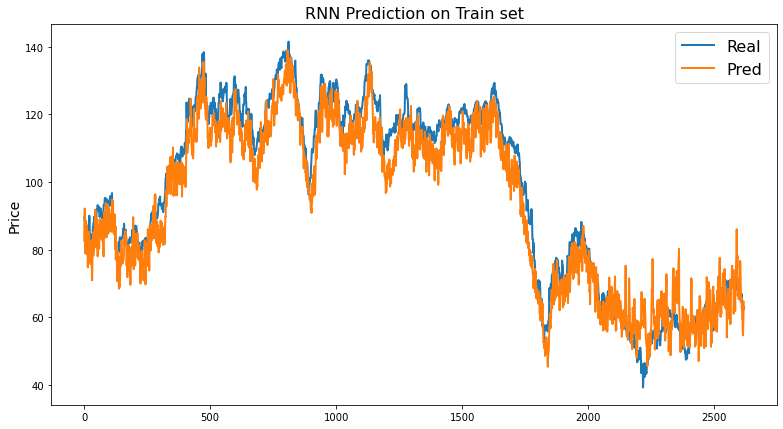

In [27]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_train, label='Real', linewidth=2)
ax.plot(pred_rnn, label='Pred', linewidth=2)
ax.set_ylabel('Price', fontsize=14)
ax.set_title('RNN Prediction on Train set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

In [28]:
pred_rnn = model_DCRNN.predict(x_test)
print('The MSE for the baseline RNN model is: {0:.2f}'.format(mean_squared_error(y_test, pred_rnn)))
print('The RMSE for the baseline RNN model is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, pred_rnn))))
print('The MAPE for the baseline RNN model is {0:.2f}'.format(mean_absolute_percentage_error(y_test, pred_rnn)))

21/21 [==============================] - 0s 1ms/step
The MSE for the baseline RNN model is: 564.86
The RMSE for the baseline RNN model is: 23.77
The MAPE for the baseline RNN model is 0.23


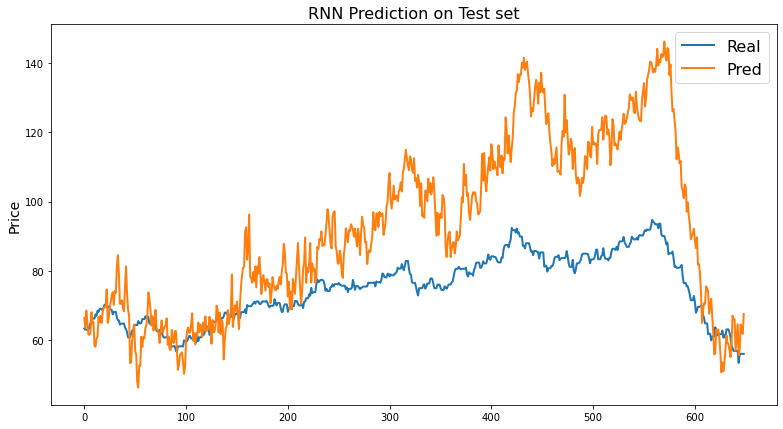

In [29]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_test, label='Real', linewidth=2)
ax.plot(pred_rnn, label='Pred', linewidth=2)
ax.set_ylabel('Price', fontsize=14)
ax.set_title('RNN Prediction on Test set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

## Feature Importance (SHAP)

- Holy Molly, shap is a way to understand feature importance through the SHAP value.
- i still trying to digest but for those who able to interpret this in layman where feel free to share with us
- What i understand, the higher the magnitude, then the features is the most influential.
- what i did now, i am using least overfitted model, which is droprnn and it shows when it february (month_2) gave the most influential (bar graph). It gave negative influential (dot graph)

#reference https://m.mage.ai/how-to-interpret-and-explain-your-machine-learning-models-using-shap-values-471c2635b78e


In [129]:
# !pip install shap

     -------------------------------------- 435.6/435.6 kB 3.9 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 19.5 MB/s eta 0:00:00
     --------------------------------------- 23.2/23.2 MB 10.6 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [178]:
dropout_RNN = Sequential()

dropout_RNN.add(SimpleRNN(units = 32, activation = 'relu', input_shape = (7,52), return_sequences = True))
dropout_RNN.add(Dropout(0.2))
dropout_RNN.add(SimpleRNN(units = 32, activation = 'relu', return_sequences = True))
dropout_RNN.add(Dropout(0.2))
dropout_RNN.add(SimpleRNN(units = 16, activation = 'relu', return_sequences = False))
dropout_RNN.add(Dense(units = 1, activation='linear'))

dropout_RNN.compile(optimizer = 'RMSprop', loss = 'mse')
dropout_RNN.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_39 (SimpleRNN)   (None, 7, 32)             2720      
                                                                 
 dropout_9 (Dropout)         (None, 7, 32)             0         
                                                                 
 simple_rnn_40 (SimpleRNN)   (None, 7, 32)             2080      
                                                                 
 dropout_10 (Dropout)        (None, 7, 32)             0         
                                                                 
 simple_rnn_41 (SimpleRNN)   (None, 16)                784       
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 5,601
Trainable params: 5,601
Non-train

In [179]:
dropout_RNN.fit(x_train, y_train, epochs = 90, validation_split= 0.2, batch_size=20, callbacks= [early_stopping])

Train on 2095 samples, validate on 524 samples
Epoch 1/90
2095/2095 [==============================] - 1s 437us/sample - loss: 4476.8010 - val_loss: 359.3164
Epoch 2/90
  20/2095 [..............................] - ETA: 0s - loss: 634.2016

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


2095/2095 [==============================] - 0s 171us/sample - loss: 340.0780 - val_loss: 174.9864
Epoch 3/90
2095/2095 [==============================] - 0s 182us/sample - loss: 230.3744 - val_loss: 106.9278
Epoch 4/90
2095/2095 [==============================] - 0s 161us/sample - loss: 188.8365 - val_loss: 110.5556
Epoch 5/90
2095/2095 [==============================] - 0s 156us/sample - loss: 163.9907 - val_loss: 78.4032
Epoch 6/90
2095/2095 [==============================] - 0s 155us/sample - loss: 147.8170 - val_loss: 81.9138
Epoch 7/90
2095/2095 [==============================] - 0s 157us/sample - loss: 125.8500 - val_loss: 74.1833
Epoch 8/90
2095/2095 [==============================] - 0s 158us/sample - loss: 117.9506 - val_loss: 93.8203
Epoch 9/90
2095/2095 [==============================] - 0s 169us/sample - loss: 114.7707 - val_loss: 53.7161
Epoch 10/90
2095/2095 [==============================] - 0s 166us/sample - loss: 104.2975 - val_loss: 64.8544
Epoch 11/90
2095/2095 [===

In [180]:
import shap

# init the JS visualization code
shap.initjs()

explainer = shap.DeepExplainer(dropout_RNN,x_train)
shap_values = explainer.shap_values(x_test)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


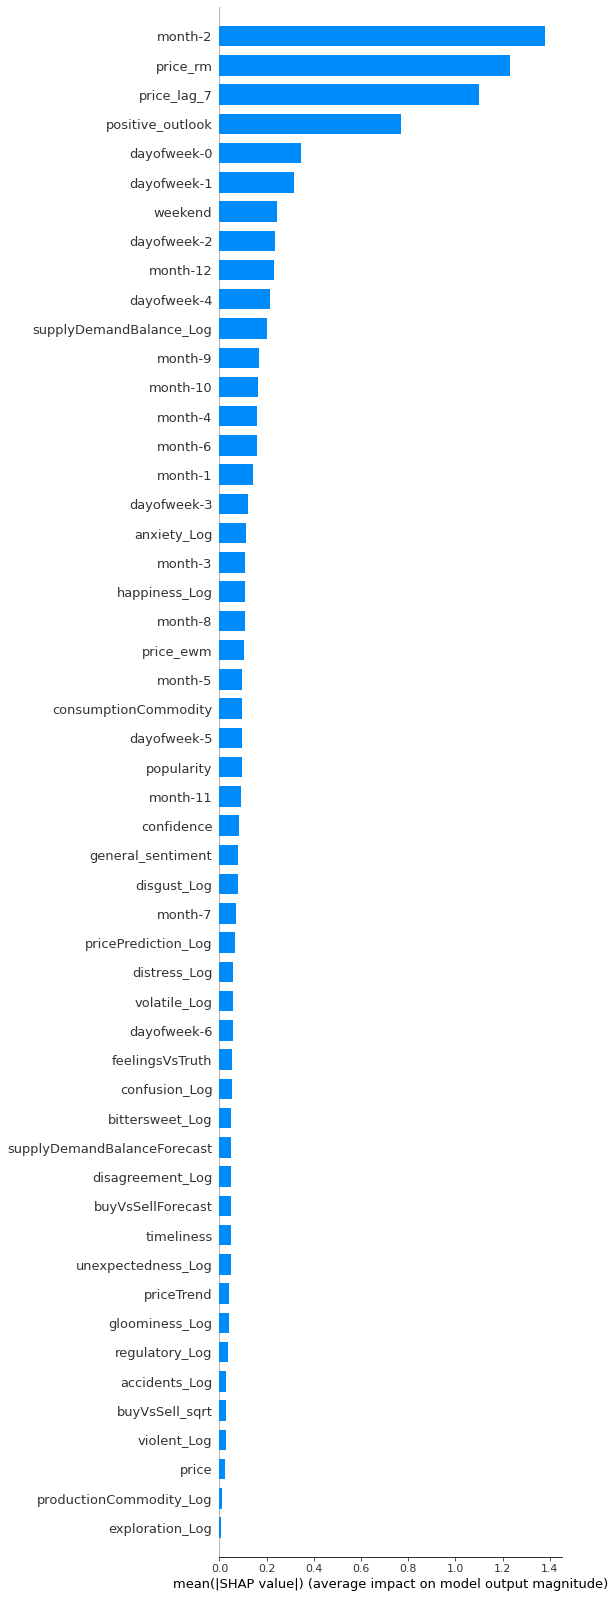

In [181]:
shap.summary_plot(shap_values[0][0], plot_type = 'bar', feature_names = df_subset.columns,max_display=52)


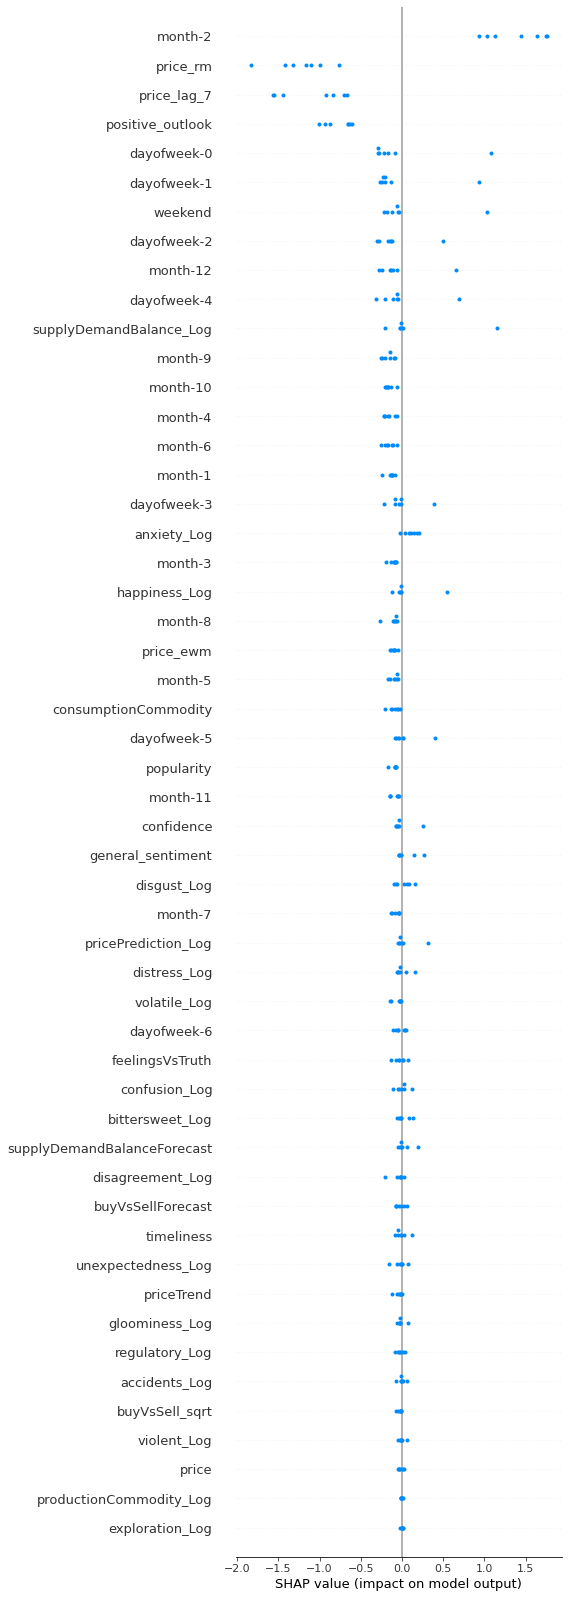

In [182]:
shap.summary_plot(shap_values[0][0], plot_type = 'dot', feature_names = df_subset.columns,max_display=52)


## Rerun with best featured

In [30]:
TheBestFeature = ['price','month-2','positive_outlook','price_lag_7','price_rm']

#We are taking the transformed columns and the derived features

df_subset = df[TheBestFeature]

In [31]:
tr_start = '2010-01-08'
tr_end = '2017-03-16' 
te_start = '2017-03-17'
te_end = '2018-12-31'

In [32]:
train = df_subset[tr_start : tr_end]
test = df_subset[te_start : te_end]

## Standardization of Independent Variables

In [33]:
x_scaler = StandardScaler()

x_scaled = x_scaler.fit_transform(train.iloc[:, 1:])

y = np.reshape(np.array(train.iloc[:,0]), (-1,1))

train_scaled = np.hstack((x_scaled, y))

In [34]:
x_scaler = StandardScaler()

x_scaled = x_scaler.fit_transform(test.iloc[:, 1:])

y = np.reshape(np.array(test.iloc[:,0]), (-1,1))

test_scaled = np.hstack((x_scaled, y))

In [35]:
train_scaled.shape

(2625, 5)

In [36]:
test_scaled.shape

(655, 5)

## Preparing dataset for modelling

In [37]:
#Defining a function to split multivariate sequences into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [38]:
x_train, y_train = split_sequences(train_scaled, 7)

In [39]:
print(x_train.shape)
print(y_train.shape)

(2619, 7, 4)
(2619,)


In [40]:
x_test, y_test = split_sequences(test_scaled, 7)

In [41]:
print(x_test.shape)
print(y_test.shape)

(649, 7, 4)
(649,)


In [42]:
dropout_RNN = Sequential()

dropout_RNN.add(SimpleRNN(units = 32, activation = 'relu', input_shape = (7,4), return_sequences = True))
dropout_RNN.add(Dropout(0.2))
dropout_RNN.add(SimpleRNN(units = 32, activation = 'relu', return_sequences = True))
dropout_RNN.add(Dropout(0.2))
dropout_RNN.add(SimpleRNN(units = 16, activation = 'relu', return_sequences = False))
dropout_RNN.add(Dense(units = 1, activation='linear'))

dropout_RNN.compile(optimizer = 'RMSprop', loss = 'mse')
dropout_RNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 7, 32)             1184      
                                                                 
 dropout_1 (Dropout)         (None, 7, 32)             0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 7, 32)             2080      
                                                                 
 dropout_2 (Dropout)         (None, 7, 32)             0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 16)                784       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,065
Trainable params: 4,065
Non-traina

In [43]:
dropout_RNN.fit(x_train, y_train, epochs = 90, validation_split= 0.2, batch_size=20, callbacks= [early_stopping])

Epoch 1/90
105/105 [==============================] - 2s 7ms/step - loss: 3123.0486 - val_loss: 686.2256
Epoch 2/90
105/105 [==============================] - 0s 4ms/step - loss: 266.1989 - val_loss: 62.9915
Epoch 3/90
105/105 [==============================] - 1s 5ms/step - loss: 159.3819 - val_loss: 53.7697
Epoch 4/90
105/105 [==============================] - 0s 4ms/step - loss: 138.6373 - val_loss: 38.9129
Epoch 5/90
105/105 [==============================] - 0s 4ms/step - loss: 129.1095 - val_loss: 32.4774
Epoch 6/90
105/105 [==============================] - 0s 4ms/step - loss: 123.0990 - val_loss: 38.1344
Epoch 7/90
105/105 [==============================] - 0s 5ms/step - loss: 113.6912 - val_loss: 121.9889
Epoch 8/90
105/105 [==============================] - 0s 4ms/step - loss: 109.0927 - val_loss: 33.0541
Epoch 9/90
105/105 [==============================] - 0s 4ms/step - loss: 102.4152 - val_loss: 84.5461
Epoch 10/90
105/105 [==============================] - 0s 4ms/step - l

In [44]:
pred_rnn = dropout_RNN.predict(x_train)
print('The MSE for the baseline RNN model is: {0:.2f}'.format(mean_squared_error(y_train, pred_rnn)))
print('The RMSE for the baseline RNN model is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_train, pred_rnn))))
print('The MAPE for the baseline RNN model is {0:.2f}'.format(mean_absolute_percentage_error(y_train, pred_rnn)))

82/82 [==============================] - 0s 2ms/step
The MSE for the baseline RNN model is: 23.61
The RMSE for the baseline RNN model is: 4.86
The MAPE for the baseline RNN model is 0.04


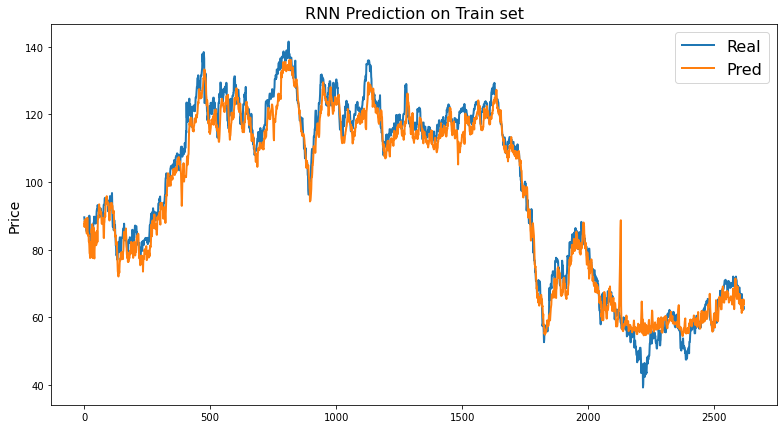

In [45]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_train, label='Real', linewidth=2)
ax.plot(pred_rnn, label='Pred', linewidth=2)
ax.set_ylabel('Price', fontsize=14)
ax.set_title('RNN Prediction on Train set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

In [46]:
pred_rnn = dropout_RNN.predict(x_test)
print('The MSE for the baseline RNN model is: {0:.2f}'.format(mean_squared_error(y_test, pred_rnn)))
print('The RMSE for the baseline RNN model is: {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, pred_rnn))))
print('The MAPE for the baseline RNN model is {0:.2f}'.format(mean_absolute_percentage_error(y_test, pred_rnn)))

21/21 [==============================] - 0s 1ms/step
The MSE for the baseline RNN model is: 569.73
The RMSE for the baseline RNN model is: 23.87
The MAPE for the baseline RNN model is 0.24


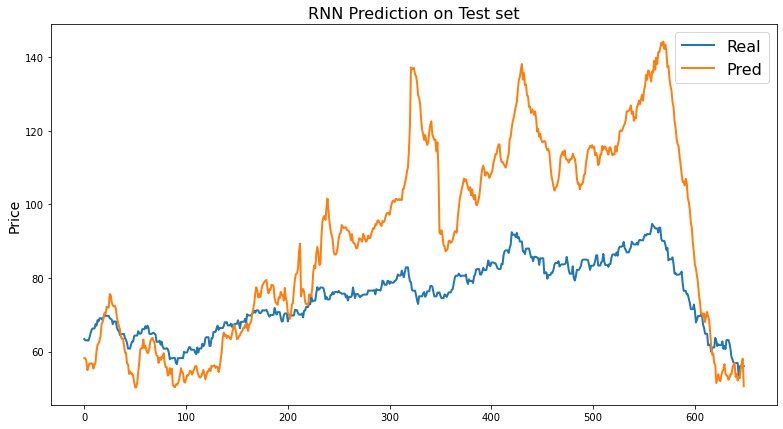

In [47]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(y_test, label='Real', linewidth=2)
ax.plot(pred_rnn, label='Pred', linewidth=2)
ax.set_ylabel('Price', fontsize=14)
ax.set_title('RNN Prediction on Test set', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

## All Parameter in one Gridsearch (RIP Laptop) (Sidi not running it, overheated laptop.)

In [ ]:
# def create_dRNN(optimizer = 'adam'):
#     dropout_RNN = Sequential()

#     dropout_RNN.add(SimpleRNN(units = 32, activation = 'relu', input_shape = (7,52), return_sequences = True))
#     dropout_RNN.add(Dropout(0.2))
#     dropout_RNN.add(SimpleRNN(units = 32, activation = 'relu', return_sequences = True))
#     dropout_RNN.add(Dropout(0.2))
#     dropout_RNN.add(SimpleRNN(units = 16, activation = 'relu', return_sequences = False))
#     dropout_RNN.add(Dense(units = 1, activation='linear'))

#     dropout_RNN.compile(optimizer = optimizer, loss = 'mse')

#     return(dropout_RNN)

In [ ]:
# AFO_RNN = KerasRegressor(build_fn=create_dRNN, verbose=1)

# #Defining the grid search parameters
# batch_size = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# epochs = [10, 30, 50, 70, 90]
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# scoring = ['neg_mean_squared_error','neg_mean_absolute_error','neg_mean_absolute_percentage_error']

# #Grid search
# param_grid = dict(batch_size=batch_size, epochs=epochs,optimizer=optimizer)
# grid = GridSearchCV(estimator=AFO_RNN, param_grid=param_grid, n_jobs=-1, cv=5, scoring=scoring, refit="neg_mean_absolute_percentage_error")
# AFO_result = grid.fit(x_train, y_train,callbacks= [early_stopping])

In [ ]:
# generate_grid_search_results_rank(AFO_result)

In [ ]:
# fname = "RNN Parameter All For One"
# generate_dataframe_grid_search_results(AFO_result,fname)

## Saving models

In [118]:
import pickle

In [51]:
from keras.models import load_model
base_RNN.save('../Models/RNN_base.h5')
opt_RNN.save('../Models/RNN_optimized.h5')
opt_RNN_es.save('../Models/RNN_optimized_es.h5')
dropout_RNN.save('../Models/RNN_optimized_dropout_es.h5')
